<a href="https://colab.research.google.com/github/Vishal487/ML-Basic-regression-fuel-efficiency-prediction/blob/master/Basic_regression_Predict_fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [ ]:
!pip install -q seaborn

!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc2


In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

## The Auto MPG dataset

**Get the data**

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data",
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
                'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                       na_values='?', comment='\t',
                       sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


#### Clean the data

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
# we're going to drop these row

dataset = dataset.dropna()

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [ ]:
dataset['Origin'].unique()

array([1, 3, 2])

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:



In [ ]:
dataset['Origin'] = dataset['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'})

In [ ]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [ ]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Euope,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [ ]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Euope,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into train and test

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the `joint-distribution` of a few pairs of columns from the training dataset

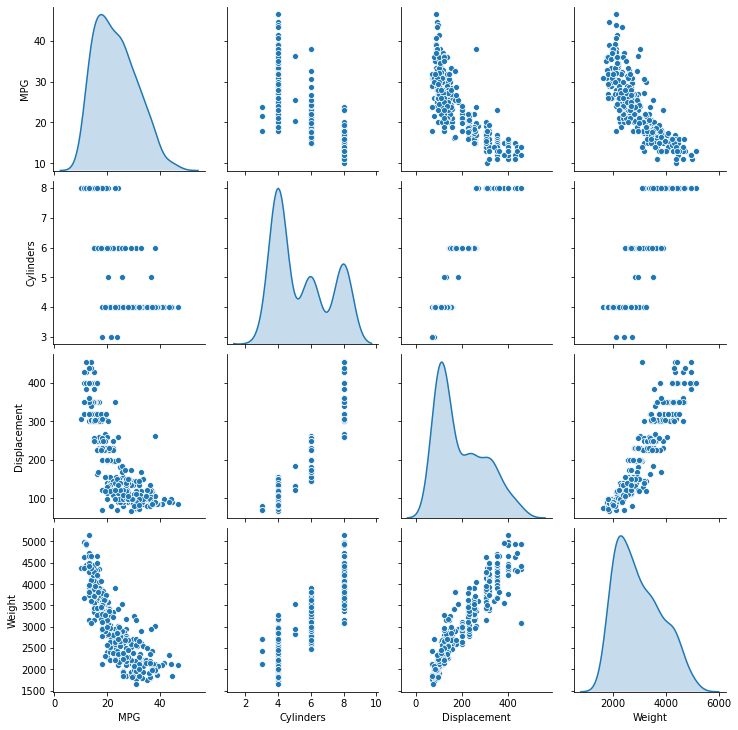

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']],
             diag_kind='kde')

In [ ]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Euope,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [ ]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Euope,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

In [ ]:
def norm(X):
    return (X-train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)     # we can do for test dataset also with same parameter as train
                                          # i.e. using mean, std of train data

# The Model
### Build the model


In [ ]:
def build_model():
    model = keras.Sequential([
                              layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Take a batch of `10` example from `training dataset` and call `model.predict` on it

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.03183684],
       [ 0.14313492],
       [-0.64689326],
       [-0.18530339],
       [ 0.04844902],
       [-0.11762939],
       [ 0.06987327],
       [-0.27670452],
       [-0.01749875],
       [ 0.2026277 ]], dtype=float32)

## Train the model

In [ ]:
EPOCHS = 1000

history = model.fit(normed_train_data,
                    train_labels,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:573.0920,  mae:22.7680,  mse:573.7748,  val_loss:562.4973,  val_mae:22.5191,  val_mse:562.7852,  
....................................................................................................
Epoch: 100, loss:5.7190,  mae:1.6997,  mse:5.7578,  val_loss:8.7843,  val_mae:2.3211,  val_mse:8.7670,  
....................................................................................................
Epoch: 200, loss:5.0572,  mae:1.5430,  mse:5.0847,  val_loss:8.4390,  val_mae:2.2235,  val_mse:8.4178,  
....................................................................................................
Epoch: 300, loss:4.3918,  mae:1.3912,  mse:4.3932,  val_loss:8.3380,  val_mae:2.1574,  val_mse:8.3283,  
....................................................................................................
Epoch: 400, loss:3.8592,  mae:1.3344,  mse:3.8821,  val_loss:8.7287,  val_mae:2.2600,  val_mse:8.7008,  
..............................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,573.091980,22.768003,573.774780,562.497314,22.519089,562.785217,0
1,522.383911,21.635448,522.157288,511.930145,21.410343,512.207947,1
2,476.098572,20.594919,475.921265,459.912354,20.219002,460.176849,2
3,426.210815,19.428284,426.637604,402.601868,18.835455,402.849274,3
4,372.677338,18.083641,372.823700,341.809265,17.259493,342.032684,4


In [ ]:
plotter  = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

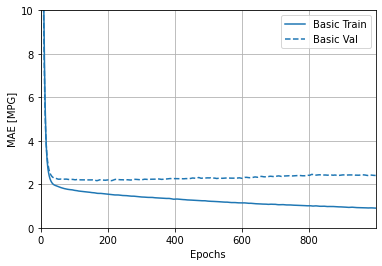

In [ ]:
plotter.plot({'Basic': history}, metric='mae')
plt.ylim([0,10])
plt.ylabel('MAE [MPG]')

So mae for training is decreasing while for validation it's increasing

Text(0, 0.5, 'MSE (MPG^2]')

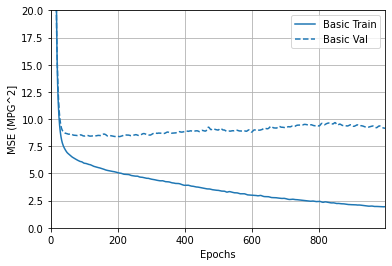

In [ ]:
plotter.plot({'Basic': history}, metric='mse')
plt.ylim([0, 20])
plt.ylabel('MSE (MPG^2]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an `EarlyStopping callback` that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

More about this callback https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
model = build_model()

# the patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data,
                          train_labels,
                          epochs=EPOCHS,
                          validation_split=0.2,
                          verbose=0,
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:588.8970,  mae:23.0126,  mse:589.4705,  val_loss:585.1375,  val_mae:22.8913,  val_mse:585.4349,  
.........................................................

Text(0, 0.5, 'MAE [MPG]')

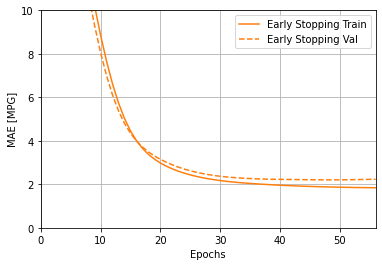

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric='mae')
plt.ylim([0,10])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print('Testing set Mean Absolute Error: {:5.2f} MPG'.format(mae))

3/3 - 0s - loss: 6.3359 - mae: 1.9074 - mse: 5.8754
Testing set Mean Absolute Error:  1.91 MPG


## Make predictions

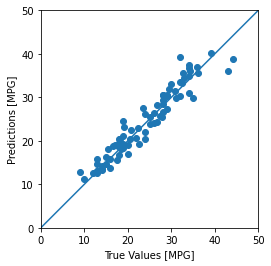

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Now let's take look at the error distribution.

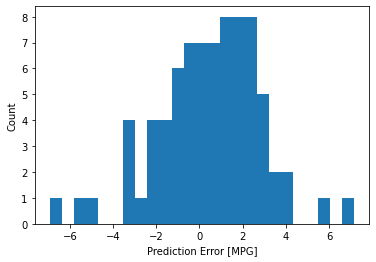

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

THANK YOU!!!